# HF GPT-2 Benchmark with Custom Modules
In this benchmark, we benchmark the effectiveness of PyTorch custom modules using HuggingFace GPT2-medium model on a NVIDIA V100 GPU.

Most steps are the same as "HF Bert Benchmark with Custom Modules".

## Setup

In [1]:
from IPython.display import clear_output
import os
import torch

!pip install datasets evaluate accelerate deepspeed psutil pybind11 huggingface_hub

clear_output()

print('Pytorch version\t:', torch.__version__)
print('PyTorch CUDA version\t:', torch.version.cuda)

for i in range(torch.cuda.device_count()):
    print(f'GPU{i}\t\t:',torch.cuda.get_device_name(i))

Pytorch version	: 1.13.0+cu117
PyTorch CUDA version	: 11.7
GPU0		: Tesla V100-SXM2-16GB
GPU1		: Tesla V100-SXM2-16GB
GPU2		: Tesla V100-SXM2-16GB
GPU3		: Tesla V100-SXM2-16GB
GPU4		: Tesla V100-SXM2-16GB
GPU5		: Tesla V100-SXM2-16GB
GPU6		: Tesla V100-SXM2-16GB
GPU7		: Tesla V100-SXM2-16GB


In [2]:
try:
    import apex
except ImportError:
    print("Installing apex")
    !git clone https://github.com/NVIDIA/apex.git || true
    clear_output()

    !cd apex; pip3 install -v --disable-pip-version-check --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

In [26]:
!git clone https://github.com/huggingface/transformers || true
!cd transformers; git reset origin/main --hard; git checkout 2bdd9fa28411a2822cd1395ed78abeef4a69ec6f
clear_output()

# Note that this patch is generated with a particular transformers commit
with open("transformers/benchmark.patch", "w") as f:
    f.write('''
diff --git a/src/transformers/trainer.py b/src/transformers/trainer.py
index c1869ef76..06d33d24b 100755
--- a/src/transformers/trainer.py
+++ b/src/transformers/trainer.py
@@ -1712,7 +1712,9 @@ class Trainer:
                 self._load_rng_state(resume_from_checkpoint)

             step = -1
+            step_metrics = {"step_time_list": []}
             for step, inputs in enumerate(epoch_iterator):
+                step_start = time.time()

                 # Skip past any already trained steps if resuming training
                 if steps_trained_in_current_epoch > 0:
@@ -1819,6 +1821,7 @@ class Trainer:
                 else:
                     self.control = self.callback_handler.on_substep_end(args, self.state, self.control)

+                step_metrics["step_time_list"].append(time.time() - step_start)
                 if self.control.should_epoch_stop or self.control.should_training_stop:
                     break
             if step < 0:
@@ -1865,6 +1868,7 @@ class Trainer:
         train_loss = self._total_loss_scalar / self.state.global_step

         metrics = speed_metrics("train", start_time, num_samples=num_train_samples, num_steps=self.state.max_steps)
+        metrics.update(step_metrics)
         self.store_flos()
         metrics["total_flos"] = self.state.total_flos
         metrics["train_loss"] = train_loss
diff --git a/src/transformers/trainer_pt_utils.py b/src/transformers/trainer_pt_utils.py
index 7ff0eb51a..ea5134e5a 100644
--- a/src/transformers/trainer_pt_utils.py
+++ b/src/transformers/trainer_pt_utils.py
@@ -867,6 +867,8 @@ def metrics_format(self, metrics: Dict[str, float]) -> Dict[str, float]:
             metrics_copy[k] = f"{ int(v) >> 30 }GF"
         elif type(metrics_copy[k]) == float:
             metrics_copy[k] = round(v, 4)
+        elif "_list" in k:
+            metrics_copy[k] = f"{','.join(str(round(e, 4)) for e in v)}"

     return metrics_copy

''')

!cd transformers; git apply benchmark.patch; rm benchmark.patch; git status

# Install the changed transformers without checking dependencies (otherwise it may ruin your PyTorch setting...)
#!cd transformers; pip install -e ".[dev]" --no-deps

HEAD detached from 12ce2941c
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   src/transformers/trainer.py
	modified:   src/transformers/trainer_pt_utils.py

no changes added to commit (use "git add" and/or "git commit -a")


In [4]:
# Whether to dump all plotted figures to PDF files.
dump_fig_to_pdf = False

## Benchmark Scripts

In [5]:
import os
import re
import json

import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from transformers import AutoConfig, PretrainedConfig

@dataclass
class Exp:
    name: str           # Experiment name
    model: str          # huggingface model name
    batch_size: int     # batch size per GPU
    seq_len: int = None # input sequence length
        
    ## Improve speed / reduce memory  
    bf16: bool = False  # Faster, less memory. Recommend if GPU supports
    fp16: bool = False  # Faster, less memory, but need to scale loos. 
                        # Recommend if BF16 is not available.
    optim: str = 'adamw_hf'  # Optimization method
    grad_ckpt: bool = False  # save memory with an extra forward
    grad_accum: int = 1      # accumulate gradients for better performance
    steps: int = 20          # number of parameter updates
        
    ## Multi-GPUs
    gpus: str = '0'          # GPUs to use. "0,1" means use GPU 0 and 1
    tensor_para: int = 1     # Tensor parallelism
    deepspeed: bool = False  # if or not use deepspeed
    ds_config: str = ''      # deepspeed config
        
    ## kwargs
    kwargs: dict = None
        
    def __post_init__(self):         
        model_conf = AutoConfig.from_pretrained(self.model)
        get = lambda *keys: max([getattr(model_conf, k) if hasattr(model_conf, k) else 0 for k in keys])
        self.num_layers = get('num_hidden_layers', 'n_layer')
        self.num_gpus = len(self.gpus.split(','))                      
        self.hidden_size = get('hidden_size', 'n_embd', 'd_model')
        self.vocab_size = get('vocab_size')
        self.num_heads = get('num_attention_heads', 'n_head')
        if self.seq_len is None:
            self.seq_len = get('max_position_embeddings', 'n_ctx')
        n, h, s, v = self.num_layers, self.hidden_size, self.seq_len, self.vocab_size
        att, ffn, embed = 4*h*s**2 + 8*s*h**2, 16*s*h**2, 2*s*h*v
        forward = n*(att+ffn) + embed
        # TFLOPs to train one example
        self.tflops = (4 * forward if self.grad_ckpt else 3 * forward) / 1e12
        if self.deepspeed:            
            self.launcher = 'deepspeed'            
        else:
            self.launcher = f'torchrun --nproc_per_node {self.num_gpus}' 
            
    def print_results(self):
        print('Total samples / second\t: %.1f' % self.samples_per_sec)
        print('Per GPU memory (GB)\t: %.1f'% self.gpu_mem)
        print('Per GPU TFLOPs\t\t: %.1f' % (self.samples_per_sec * self.tflops / self.num_gpus))

In [6]:
%config InlineBackend.figure_formats = ['svg']

def compare(exps, save_to=""):
    fig, ax = plt.subplots(ncols=3, figsize=(9,len(exps)/2))
    x = list(range(len(exps)))
    for i, (y, l) in enumerate((
        ([e.samples_per_sec for e in exps], 'Samples / sec'), 
        ([e.samples_per_sec * e.tflops / e.num_gpus for e in exps], 'per GPU TFLOPS'),
        ([e.gpu_mem for e in exps], 'per GPU memory (GB)'))):
        print(f"{l}: {['%.2f' % e for e in y]}")
        ax[i].barh(x, y, align='center', height=0.6, color=plt.get_cmap('Set1')(x))
        ax[i].invert_yaxis()
        ax[i].set_xlabel(l)
        if i == 0:
            ax[i].set_yticks(x, labels=[e.name for e in exps])
        else:
            ax[i].set_yticklabels([])

    if save_to:
        plt.savefig(save_to, bbox_inches="tight")
    else:
        plt.show()

In [32]:
def hf_gpt(exp):
    cmd = f'''CUDA_VISIBLE_DEVICES={exp.gpus} \
{exp.launcher} transformers/examples/pytorch/language-modeling/run_clm.py \
--config_name {exp.model} --tokenizer_name {exp.model} \
--dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 \
--do_train --per_device_train_batch_size {exp.batch_size} \
--block_size {exp.seq_len} --learning_rate 2e-5 \
--max_steps {exp.steps} --optim {exp.optim} \
--fp16 {exp.fp16} --bf16 {exp.bf16} \
--gradient_accumulation_steps {exp.grad_accum} \
--gradient_checkpointing {exp.grad_ckpt} \
--report_to none \
--output_dir /tmp/gpt/ --overwrite_output_dir yes --skip_memory_metrics False'''
    if exp.deepspeed:
        cmd += f' --deepspeed {exp.ds_config}'
    cmd += ' > log.txt 2>&1'
    print(cmd)
    os.system(cmd)
    ret = hf_log(exp, 'log.txt')
    if ret is not None:
        ret.print_results()
    return ret

    
def hf_log(exp, log_filename):
    with open(log_filename) as f:
        lines = f.readlines()
        
    global_batch_size = 0
    for l in lines:
        if 'CUDA out of memory' in l:
            print('Out of GPU memory, try a smaller batch size')
            return None
        if 'Total train batch size' in l:
            global_batch_size = int(next(iter(reversed(re.findall('= +([\d\.]+)', l))), 0))
        if '{\'train_runtime' in l:
            if global_batch_size == 0:
                print(f'Failed to parse global batch size. Check {log_filename} to find error')
            metrics = json.loads(l.replace('\'', '\"'))
            exp.gpu_mem = (metrics['init_mem_cpu_peaked_delta'] + \
                    metrics['train_mem_gpu_alloc_delta'] + metrics['train_mem_gpu_peaked_delta']) / 1e9
            if 'step_time_list' in metrics:
                step_time_list = metrics['step_time_list']
                # Remove the first 5 iterations (warmup)
                step_time_list = step_time_list[5:] if len(step_time_list) > 5 else step_time_list
                exp.samples_per_sec = (global_batch_size * len(step_time_list)) / sum(step_time_list)
            else:
                print("Cannot find 'step_time_list', use HF Triner reported samples/sec")
                exp.samples_per_sec = metrics['train_samples_per_second']
            return exp
    print(f'Failed. Check "{log_filename}" to find error')    
    return None

## Benchmark

In [8]:
v1 = hf_gpt(Exp('Vanilla(bs1)', 'gpt2-medium', 1, fp16=True, optim='adamw_apex_fused',
            kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))

Total samples / second	: 4.1
Per GPU memory (GB)	: 13.2
Per GPU TFLOPs		: 10.1


Samples / sec: ['4.09']
per GPU TFLOPS: ['10.15']
per GPU memory (GB): ['13.23']


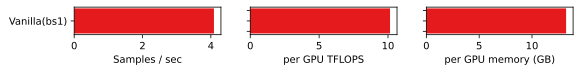

In [9]:
# Plot results
compare([v1], "vanilla.pdf" if dump_fig_to_pdf else None)

## Setup epoi and xFormers

In [10]:
def build_package(name, url):
    import importlib
    import os, sys
    if importlib.util.find_spec(name) is None:
        os.system(f"git clone {url} {name} || true")
        os.system(f"cd {name}; git submodule update --init --recursive")
        os.system(f"cd {name}; pip3 install -r requirements.txt || true")
        os.system(f'cd {name}; pip3 install -e ".[dev]"') 

build_package("xformers", "https://github.com/facebookresearch/xformers.git")
build_package("epoi", "https://github.com/comaniac/epoi.git")

### Replace Softmax

In [27]:
with open("transformers/patch", "w") as f:
    f.write('''
diff --git a/src/transformers/models/gpt2/modeling_gpt2.py b/src/transformers/models/gpt2/modeling_gpt2.py
index 109abb215..065769ed9 100644
--- a/src/transformers/models/gpt2/modeling_gpt2.py
+++ b/src/transformers/models/gpt2/modeling_gpt2.py
@@ -46,6 +46,10 @@ from ...utils import (
 from ...utils.model_parallel_utils import assert_device_map, get_device_map
 from .configuration_gpt2 import GPT2Config

+try:
+    from xformers.triton.softmax import softmax as xformers_softmax
+except ImportError:
+    xformers_softmax = None

 logger = logging.get_logger(__name__)

@@ -204,7 +208,8 @@ class GPT2Attention(nn.Module):
             # Apply the attention mask
             attn_weights = attn_weights + attention_mask

-        attn_weights = nn.functional.softmax(attn_weights, dim=-1)
+        assert xformers_softmax is not None
+        attn_weights = xformers_softmax(attn_weights)

         # Downcast (if necessary) back to V's dtype (if in mixed-precision) -- No-Op otherwise
         attn_weights = attn_weights.type(value.dtype)
@@ -254,7 +259,8 @@ class GPT2Attention(nn.Module):
             # Apply the attention mask
             attn_weights = attn_weights + attention_mask

-        attn_weights = nn.functional.softmax(attn_weights, dim=-1)
+        assert xformers is not None
+        attn_weights = xformers_softmax(attn_weights, dim=-1)

         # Downcast (if necessary) back to V's dtype (if in mixed-precision) -- No-Op if otherwise
         if attn_weights.dtype != torch.float32:
''')

!cd transformers; git apply patch; rm patch; git diff src/transformers/models/gpt2/modeling_gpt2.py

diff --git a/src/transformers/models/gpt2/modeling_gpt2.py b/src/transformers/models/gpt2/modeling_gpt2.py
index c32b1465a..8534be605 100644
--- a/src/transformers/models/gpt2/modeling_gpt2.py
+++ b/src/transformers/models/gpt2/modeling_gpt2.py
@@ -46,6 +46,10 @@ from ...utils import (
 from ...utils.model_parallel_utils import assert_device_map, get_device_map
 from .configuration_gpt2 import GPT2Config
 
+try:
+    from xformers.triton.softmax import softmax as xformers_softmax
+except ImportError:
+    xformers_softmax = None
 
 logger = logging.get_logger(__name__)
 
@@ -204,7 +208,8 @@ class GPT2Attention(nn.Module):
             # Apply the attention mask
             attn_weights = attn_weights + attention_mask
 
-        attn_weights = nn.functional.softmax(attn_weights, dim=-1)
+        assert xformers_softmax is not None
+        attn_weights = xformers_softmax(attn_weights)
 
         # Downcast (if necessary) back to V's dtype (if in mixed-precision) -- No-Op otherwise
    

In [12]:
v2 = hf_gpt(Exp('+softmax(bs1)', 'gpt2-medium', 1, fp16=True, optim='adamw_apex_fused',
            kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))

Total samples / second	: 3.8
Per GPU memory (GB)	: 13.5
Per GPU TFLOPs		: 9.5


Samples / sec: ['4.09', '3.82']
per GPU TFLOPS: ['10.15', '9.47']
per GPU memory (GB): ['13.23', '13.50']


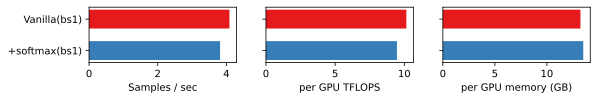

In [13]:
compare([v1, v2], "add_softmax.pdf" if dump_fig_to_pdf else None)

### Replace Attention Layer
1. Note that this patch is on top of the previous patch.
2. We replace GPT2Attention with xFormers' FlashAttention implementation, which is memory efficient and could support a larger batch size. On the other hand, the current CUTLASS kernel for FlashAttntion doesn't support attention mask, so the result is actually incorrect. We will fix that in the future.

In [28]:
with open("transformers/patch", "w") as f:
    f.write('''
diff --git a/src/transformers/models/gpt2/modeling_gpt2.py b/src/transformers/models/gpt2/modeling_gpt2.py
index c00dd5b2d..e307cc88b 100644
--- a/src/transformers/models/gpt2/modeling_gpt2.py
+++ b/src/transformers/models/gpt2/modeling_gpt2.py
@@ -370,7 +370,8 @@ class GPT2Block(nn.Module):
         inner_dim = config.n_inner if config.n_inner is not None else 4 * hidden_size

         self.ln_1 = nn.LayerNorm(hidden_size, eps=config.layer_norm_epsilon)
-        self.attn = GPT2Attention(config, layer_idx=layer_idx)
+        from epoi.ops.xformers_attn import GPT2AttentionWithXF
+        self.attn = GPT2AttentionWithXF(config, layer_idx=layer_idx)
         self.ln_2 = nn.LayerNorm(hidden_size, eps=config.layer_norm_epsilon)

         if config.add_cross_attention:
''')

!cd transformers; git apply patch; rm patch; git diff src/transformers/models/gpt2/modeling_gpt2.py

diff --git a/src/transformers/models/gpt2/modeling_gpt2.py b/src/transformers/models/gpt2/modeling_gpt2.py
index c32b1465a..897985e39 100644
--- a/src/transformers/models/gpt2/modeling_gpt2.py
+++ b/src/transformers/models/gpt2/modeling_gpt2.py
@@ -46,6 +46,10 @@ from ...utils import (
 from ...utils.model_parallel_utils import assert_device_map, get_device_map
 from .configuration_gpt2 import GPT2Config
 
+try:
+    from xformers.triton.softmax import softmax as xformers_softmax
+except ImportError:
+    xformers_softmax = None
 
 logger = logging.get_logger(__name__)
 
@@ -204,7 +208,8 @@ class GPT2Attention(nn.Module):
             # Apply the attention mask
             attn_weights = attn_weights + attention_mask
 
-        attn_weights = nn.functional.softmax(attn_weights, dim=-1)
+        assert xformers_softmax is not None
+        attn_weights = xformers_softmax(attn_weights)
 
         # Downcast (if necessary) back to V's dtype (if in mixed-precision) -- No-Op otherwise
    

In [34]:
v3_bs1 = hf_gpt(Exp('+flash_attn(bs1)', 'gpt2-medium', 1, fp16=True, optim='adamw_apex_fused',
                kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))

CUDA_VISIBLE_DEVICES=0 torchrun --nproc_per_node 1 transformers/examples/pytorch/language-modeling/run_clm.py --config_name gpt2-medium --tokenizer_name gpt2-medium --dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 --do_train --per_device_train_batch_size 1 --block_size 1024 --learning_rate 2e-5 --max_steps 20 --optim adamw_apex_fused --fp16 True --bf16 False --gradient_accumulation_steps 1 --gradient_checkpointing False --report_to none --output_dir /tmp/gpt/ --overwrite_output_dir yes --skip_memory_metrics False > log.txt 2>&1
Total samples / second	: 4.2
Per GPU memory (GB)	: 10.4
Per GPU TFLOPs		: 10.4


In [35]:
v3_bs2 = hf_gpt(Exp('+flash_attn(bs2)', 'gpt2-medium', 2, fp16=True, optim='adamw_apex_fused',
                kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))

CUDA_VISIBLE_DEVICES=0 torchrun --nproc_per_node 1 transformers/examples/pytorch/language-modeling/run_clm.py --config_name gpt2-medium --tokenizer_name gpt2-medium --dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 --do_train --per_device_train_batch_size 2 --block_size 1024 --learning_rate 2e-5 --max_steps 20 --optim adamw_apex_fused --fp16 True --bf16 False --gradient_accumulation_steps 1 --gradient_checkpointing False --report_to none --output_dir /tmp/gpt/ --overwrite_output_dir yes --skip_memory_metrics False > log.txt 2>&1
Total samples / second	: 7.3
Per GPU memory (GB)	: 13.1
Per GPU TFLOPs		: 18.2


Samples / sec: ['4.09', '3.82', '4.18', '7.34']
per GPU TFLOPS: ['10.15', '9.47', '10.38', '18.21']
per GPU memory (GB): ['13.23', '13.50', '10.39', '13.08']


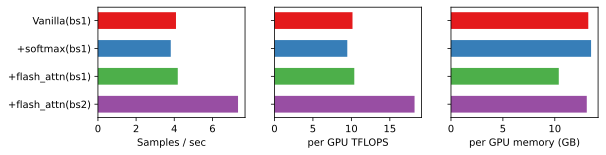

In [36]:
compare([v1, v2, v3_bs1, v3_bs2], "add_flash_attn.pdf" if dump_fig_to_pdf else None)

### Replace Bias+GELU

In [37]:
with open("transformers/patch", "w") as f:
    f.write('''
diff --git a/src/transformers/models/gpt2/modeling_gpt2.py b/src/transformers/models/gpt2/modeling_gpt2.py
index 44602b8d5..f68291c28 100644
--- a/src/transformers/models/gpt2/modeling_gpt2.py
+++ b/src/transformers/models/gpt2/modeling_gpt2.py
@@ -350,10 +350,19 @@ class GPT2MLP(nn.Module):
     def __init__(self, intermediate_size, config):
         super().__init__()
         embed_dim = config.hidden_size
-        self.c_fc = Conv1D(intermediate_size, embed_dim)
         self.c_proj = Conv1D(embed_dim, intermediate_size)
-        self.act = ACT2FN[config.activation_function]
         self.dropout = nn.Dropout(config.resid_pdrop)
+        if config.activation_function == "gelu_new":
+            from epoi.ops.torchscript_ops import MM, FusedBiasNewGELU
+            self.c_fc = MM(intermediate_size, embed_dim, bias=False)
+            self.act = FusedBiasNewGELU(intermediate_size, prev_weight=self.c_fc.weight)
+        elif config.activation_function == "gelu":
+            from epoi.ops.torchscript_ops import MM, FusedBiasGELU
+            self.c_fc = MM(intermediate_size, embed_dim, bias=False)
+            self.act = FusedBiasGELU(intermediate_size, prev_weight=self.c_fc.weight)
+        else:
+            self.c_fc = Conv1D(intermediate_size, embed_dim)
+            self.act = ACT2FN[config.activation_function]

     def forward(self, hidden_states: Optional[Tuple[torch.FloatTensor]]) -> torch.FloatTensor:
         hidden_states = self.c_fc(hidden_states)
''')

!cd transformers; git apply patch; rm patch; git diff src/transformers/models/gpt2/modeling_gpt2.py

diff --git a/src/transformers/models/gpt2/modeling_gpt2.py b/src/transformers/models/gpt2/modeling_gpt2.py
index c32b1465a..ea56f2d2e 100644
--- a/src/transformers/models/gpt2/modeling_gpt2.py
+++ b/src/transformers/models/gpt2/modeling_gpt2.py
@@ -46,6 +46,10 @@ from ...utils import (
 from ...utils.model_parallel_utils import assert_device_map, get_device_map
 from .configuration_gpt2 import GPT2Config
 
+try:
+    from xformers.triton.softmax import softmax as xformers_softmax
+except ImportError:
+    xformers_softmax = None
 
 logger = logging.get_logger(__name__)
 
@@ -204,7 +208,8 @@ class GPT2Attention(nn.Module):
             # Apply the attention mask
             attn_weights = attn_weights + attention_mask
 
-        attn_weights = nn.functional.softmax(attn_weights, dim=-1)
+        assert xformers_softmax is not None
+        attn_weights = xformers_softmax(attn_weights)
 
         # Downcast (if necessary) back to V's dtype (if in mixed-precision) -- No-Op otherwise
    

In [38]:
v4_bs2 = hf_gpt(Exp('+bias_gelu(bs2)', 'gpt2-medium', 2, fp16=True, optim='adamw_apex_fused',
                kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))

CUDA_VISIBLE_DEVICES=0 torchrun --nproc_per_node 1 transformers/examples/pytorch/language-modeling/run_clm.py --config_name gpt2-medium --tokenizer_name gpt2-medium --dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 --do_train --per_device_train_batch_size 2 --block_size 1024 --learning_rate 2e-5 --max_steps 20 --optim adamw_apex_fused --fp16 True --bf16 False --gradient_accumulation_steps 1 --gradient_checkpointing False --report_to none --output_dir /tmp/gpt/ --overwrite_output_dir yes --skip_memory_metrics False > log.txt 2>&1
Total samples / second	: 7.8
Per GPU memory (GB)	: 12.3
Per GPU TFLOPs		: 19.3


Samples / sec: ['4.09', '3.82', '4.18', '7.34', '7.78']
per GPU TFLOPS: ['10.15', '9.47', '10.38', '18.21', '19.30']
per GPU memory (GB): ['13.23', '13.50', '10.39', '13.08', '12.28']


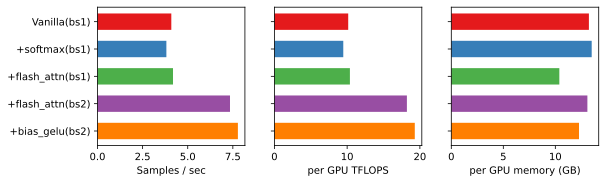

In [39]:
compare([v1, v2, v3_bs1, v3_bs2, v4_bs2], "add_bias_gelu.pdf" if dump_fig_to_pdf else None)